# Tensorflow Model

In [160]:
from os import path
from random import sample, seed

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


In [165]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 2000
EPOCHS = 10

seed(50)

### Load, split, and normalize the training data

In [91]:
def load_raw_evalmetrics_df():
    return pd.read_pickle(path.join('.', 'raw_evalmetrics_df.pkl'))

def prep_multivarate(df):
    """ Calculates density and removes unnecessary columns """
    new_df = df.copy()
    new_df['density'] = df.latestTotalPopulation / df.LND110210
    new_df = new_df.drop(columns=['latestTotalPopulation','fips','LND110210'])
    return new_df

def split_sample(df, percent_train=.80):
    county = set(df.county)
    train_county = sample(county, int(len(county) * percent_train))
    val_county = county - set(train_county)
    train_filter = [c in train_county for c in df.county]
    val_filter = [c in val_county for c in df.county]
    return df[train_filter].fillna(0), df[val_filter].fillna(0)

def normalize_df(train_df, val_df):
    new_train_df = train_df.copy()
    new_val_df = val_df.copy()
#     cols = ['confirmed_cases','confirmed_deaths', 'confirmed_recoveries','hospitalIcuBeds','hospitalStaffedBeds','hospitalLicensedBeds', 'density']
    cols = ['confirmed_cases','confirmed_recoveries','hospitalIcuBeds','hospitalStaffedBeds','hospitalLicensedBeds', 'density']
    for col in cols:
        # calculate mean and std on training data only
        data = new_train_df[col].astype('float')
        data_mean = data.mean(axis=0)
        data_std = data.std(axis=0)
        new_train_df[col] = (data-data_mean)/data_std
        #apply to val data
        data = new_val_df[col].astype('float')
        new_val_df[col] = (data-data_mean)/data_std
    return new_train_df.fillna(0), new_val_df.fillna(0)

def get_data():
    evalmetric_df = load_raw_evalmetrics_df()
    prepped_df = prep_multivarate(evalmetric_df)
    train_df, val_df = split_sample(prepped_df)
    return normalize_df(train_df, val_df)



### Prep the data for RNN

In [92]:
# inspired by https://www.tensorflow.org/tutorials/structured_data/time_series


def multivariate_data(dataset, target_col, history_size=20, target_size=0):
    data = []
    labels = []
    
    counties = set(dataset.county)
    
    for j, county in enumerate(counties):
        if (j + 1) % 100 == 0:
            print('.', end='')
        sub_dataset = dataset[dataset.county == county]
        target = sub_dataset[target_col].values
        sub_dataset = sub_dataset.drop(columns=['county', 'date'])
        sub_dataset = sub_dataset.values
        start_index = history_size
        end_index = len(sub_dataset) - target_size

        for i in range(start_index, end_index):
            indices = range(i-history_size, i)
            data.append(sub_dataset[indices])

            labels.append(target[i+target_size])

    print()
    return np.array(data), np.array(labels)



### Build the Tensorflow model

In [168]:
def slice_cache_for_tensorflow(x_train, y_train, x_val, y_val):
    x_train = np.asarray(x_train).astype(np.float32)
    y_train = np.asarray(y_train).astype(np.float32)
    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data = train_data.cache().shuffle(BUFFER_SIZE, seed=50).batch(BATCH_SIZE).repeat()

    x_val = np.asarray(x_val).astype(np.float32)
    y_val = np.asarray(y_val).astype(np.float32)
    val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_data = val_data.batch(BATCH_SIZE).repeat()
    
    return train_data, val_data

def build_and_compile_model(x_train):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(32, input_shape=x_train.shape[-2:]))
    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
    return model

def build_and_compile_deep_model(x_train):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:]))
    model.add(tf.keras.layers.LSTM(16, activation='relu'))
    model.add(tf.keras.layers.Dense(72))
    # model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
    return model


def fit_model(model, train_data, val_data):
    history = model.fit(train_data, epochs=EPOCHS,
                            steps_per_epoch=EVALUATION_INTERVAL,
                            validation_data=val_data,
                            validation_steps=50)
    return history
    
    

In [170]:
tf.random.set_seed(50)
train_df, val_df = get_data()
x_train, y_train = multivariate_data(train_df, 'confirmed_deaths')
x_val, y_val = multivariate_data(val_df, 'confirmed_deaths')

train_data, val_data = slice_cache_for_tensorflow(x_train, y_train, x_val, y_val)
shallow_model = build_and_compile_model(x_train)
deep_model = build_and_compile_deep_model(x_train)
shallow_history = fit_model(shallow_model, train_data, val_data)
deep_history = fit_model(deep_model, train_data, val_data)






......
.
Epoch 1/10
2000/2000 [==============================] - 58s 29ms/step - loss: 9.2771 - val_loss: 4.4025
Epoch 2/10
2000/2000 [==============================] - 58s 29ms/step - loss: 9.0913 - val_loss: 4.3490
Epoch 3/10
2000/2000 [==============================] - 59s 30ms/step - loss: 9.0244 - val_loss: 4.3122
Epoch 4/10
2000/2000 [==============================] - 59s 29ms/step - loss: 8.9775 - val_loss: 4.3011
Epoch 5/10
2000/2000 [==============================] - 58s 29ms/step - loss: 8.8792 - val_loss: 4.2679
Epoch 6/10
2000/2000 [==============================] - 47s 24ms/step - loss: 8.8511 - val_loss: 4.2596
Epoch 7/10
2000/2000 [==============================] - 50s 25ms/step - loss: 8.7954 - val_loss: 4.2541
Epoch 8/10
2000/2000 [==============================] - 58s 29ms/step - loss: 8.7262 - val_loss: 4.1886
Epoch 9/10
2000/2000 [==============================] - 59s 29ms/step - loss: 8.6369 - val_loss: 4.1664
Epoch 10/10
2000/2000 [==============================] 

### Plots

In [171]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

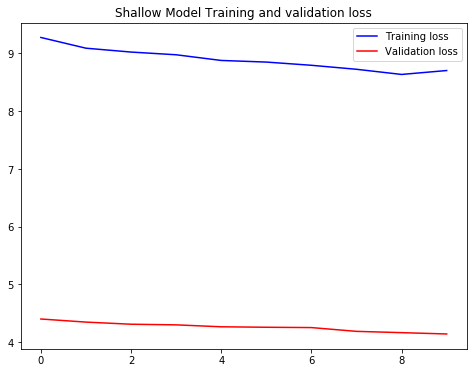

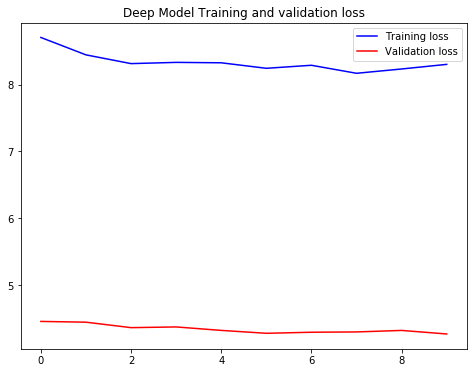

In [173]:
plot_train_history(shallow_history,
                   'Shallow Model Training and validation loss')

plot_train_history(deep_history,
                   'Deep Model Training and validation loss')

In [144]:
history

In [174]:
def create_time_steps(length):
    return list(range(-length, 0))


In [175]:
def show_plot(plot_data, delta, title):
    
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

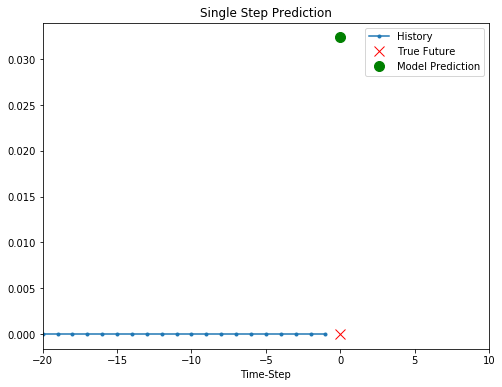

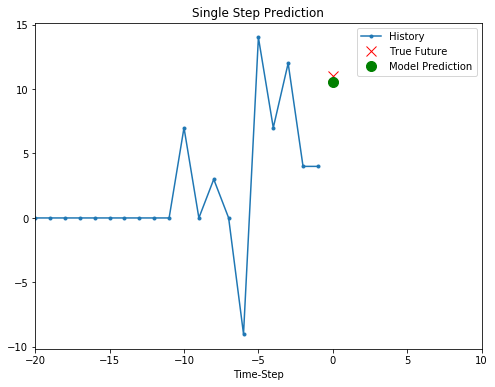

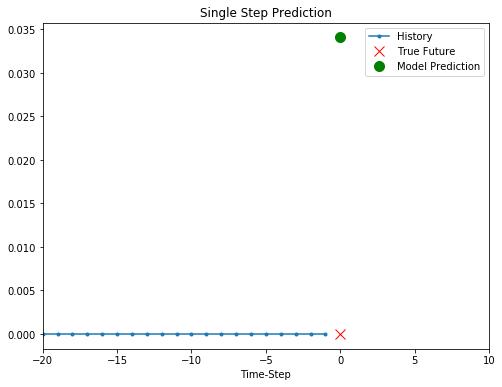

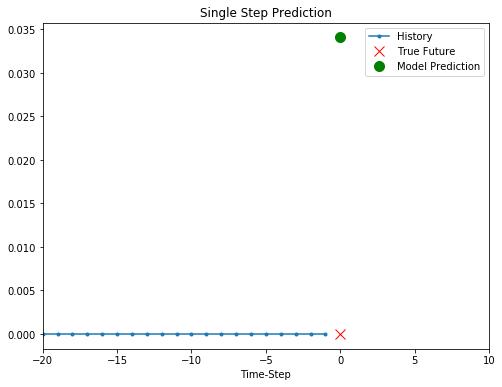

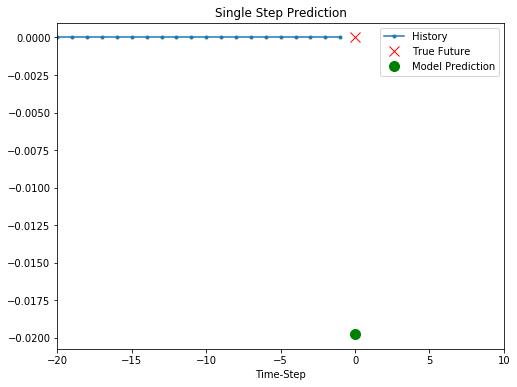

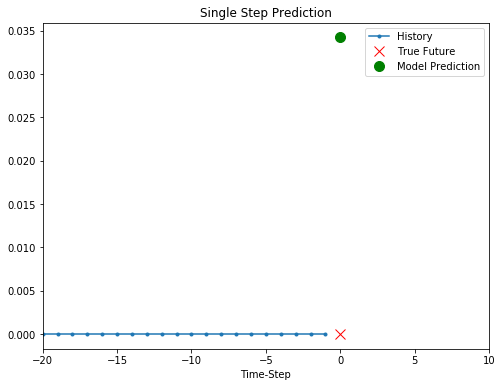

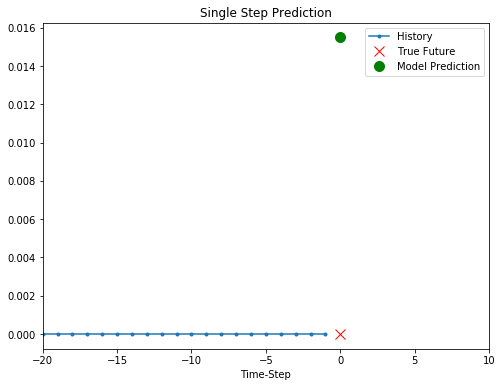

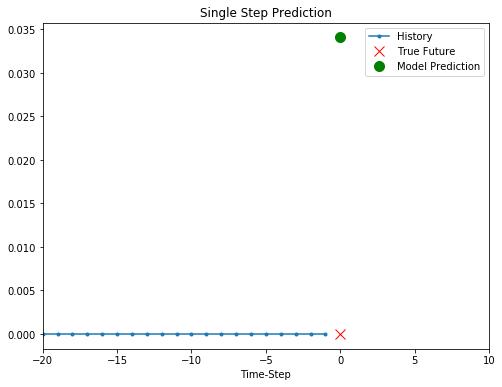

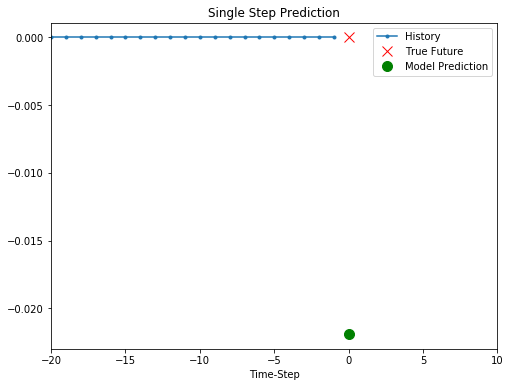

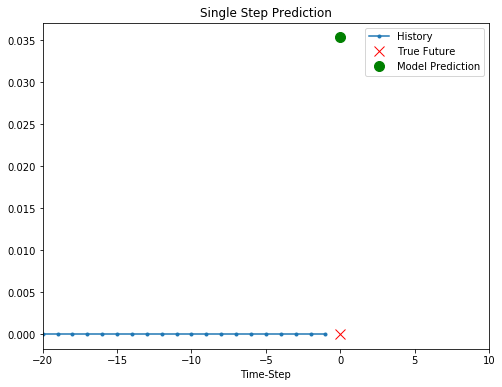

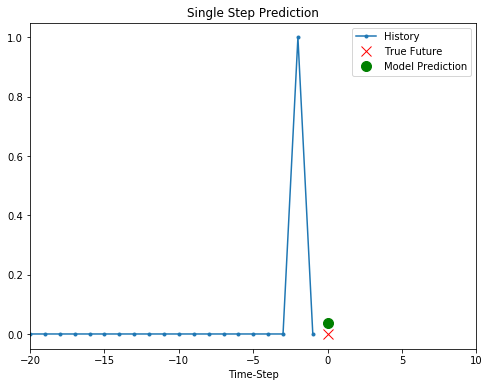

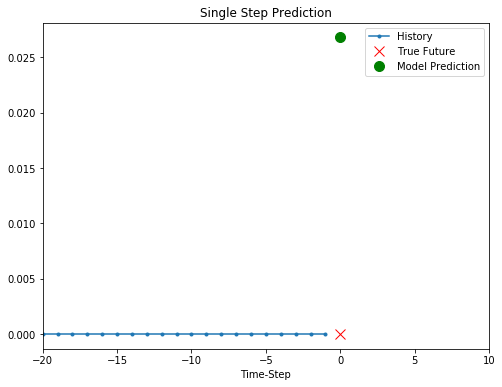

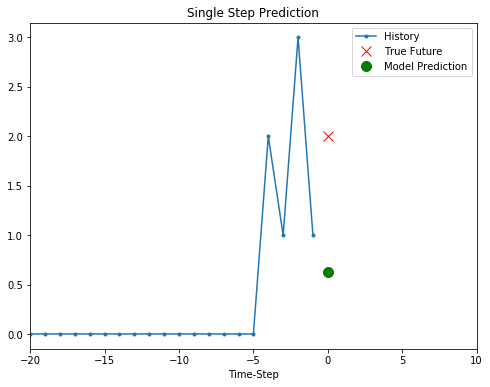

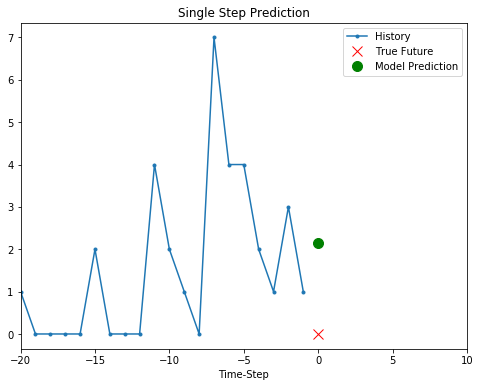

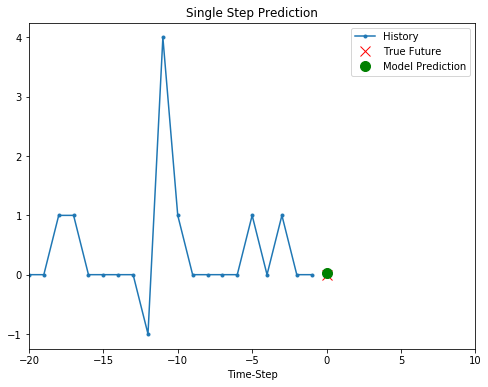

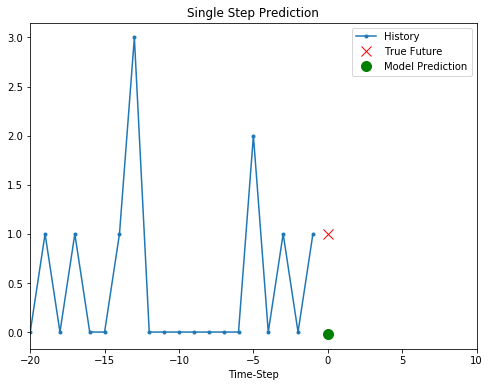

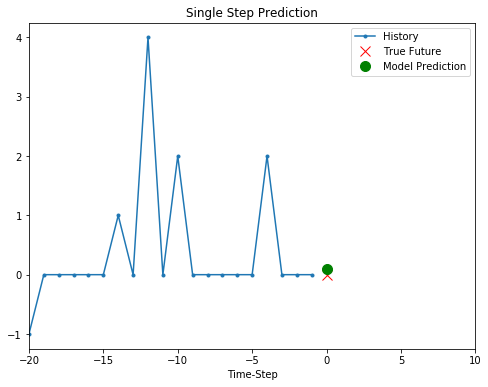

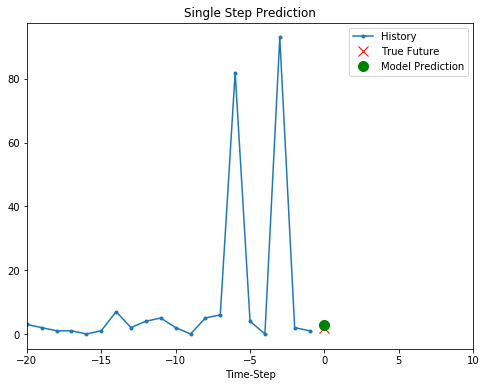

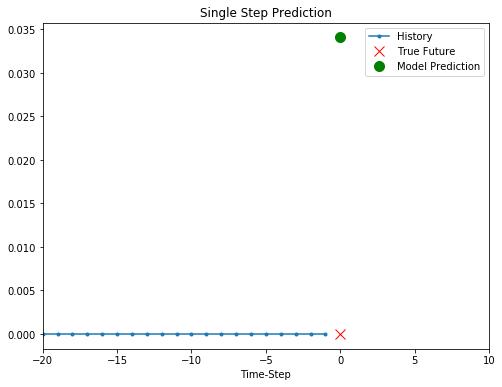

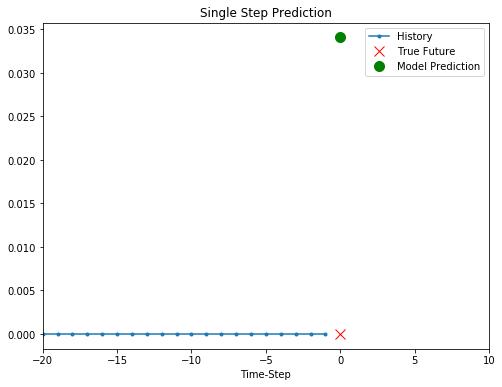

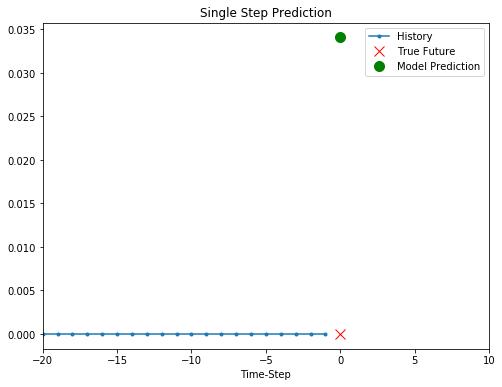

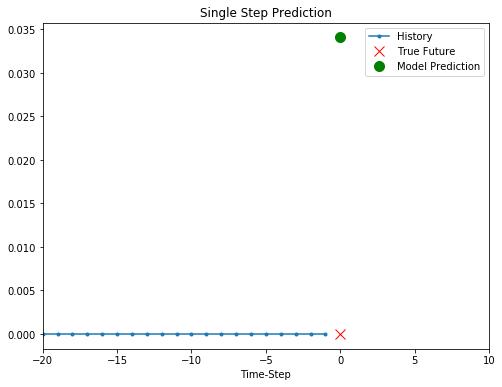

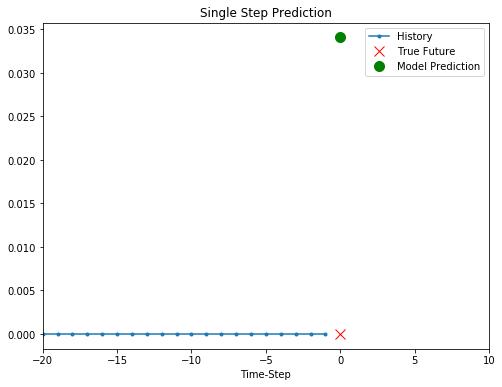

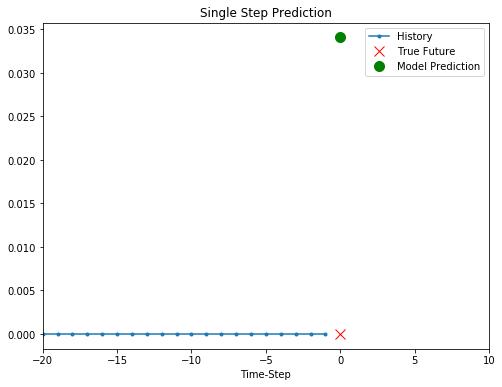

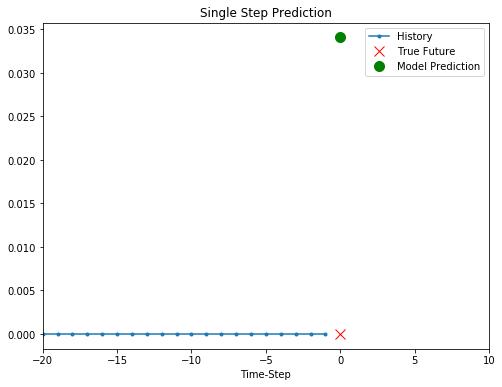

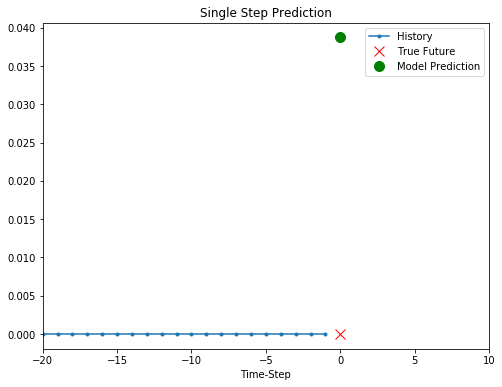

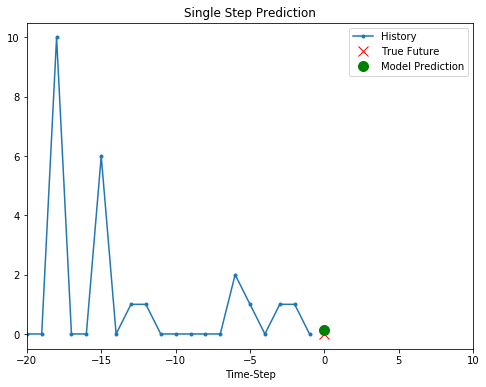

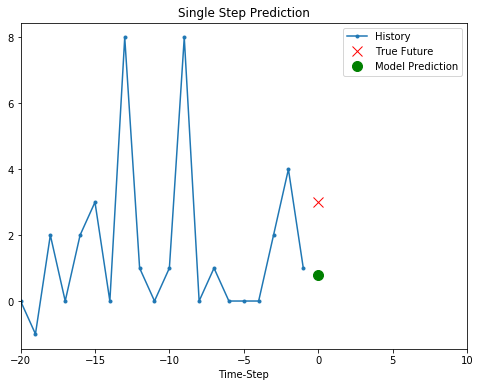

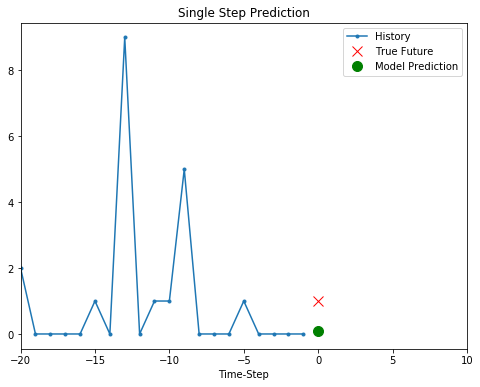

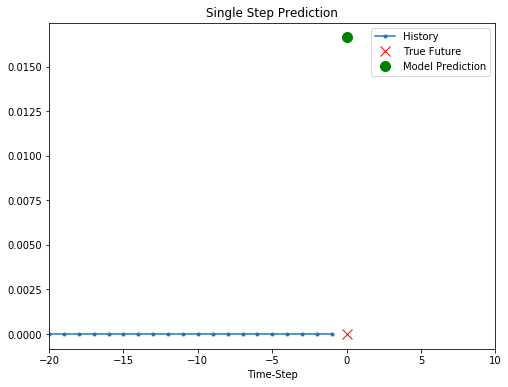

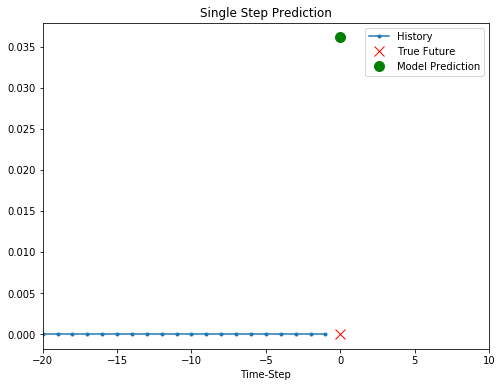

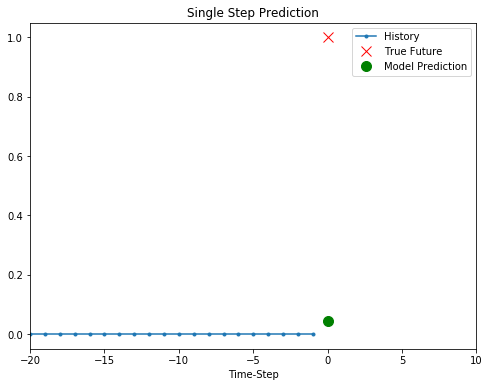

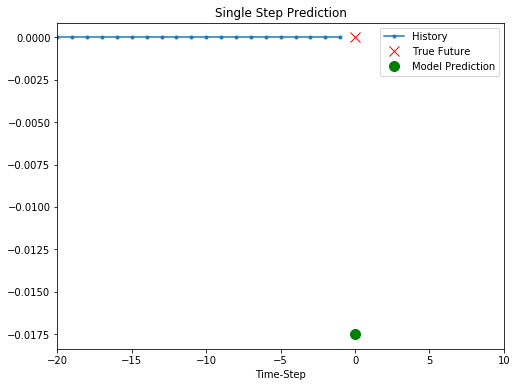

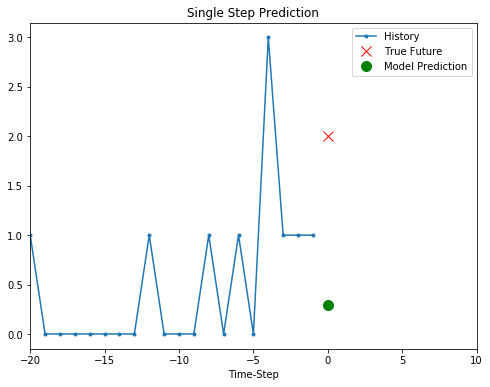

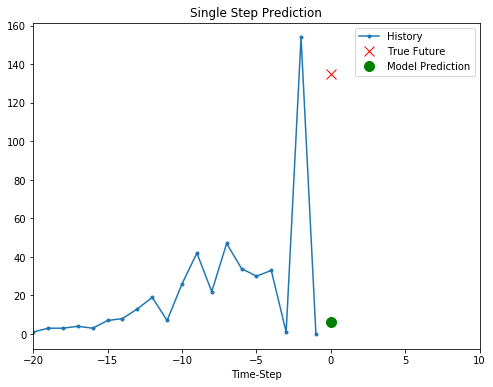

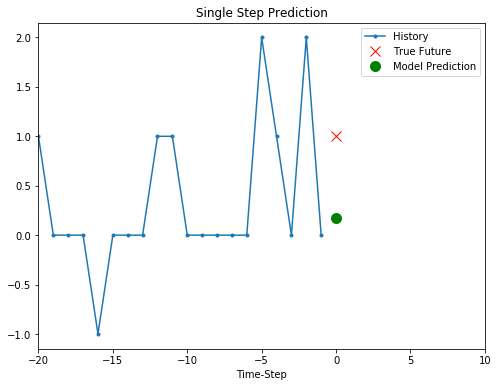

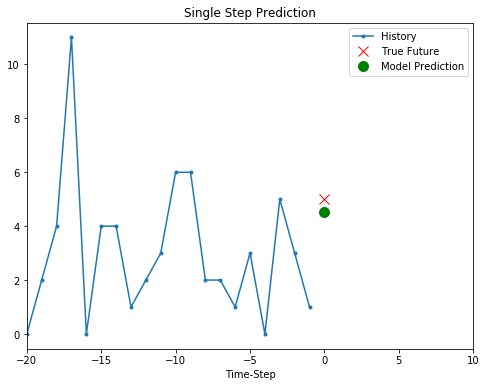

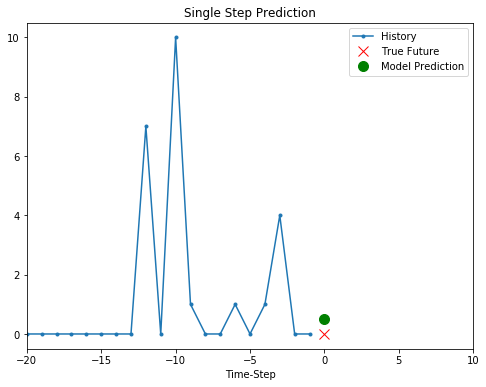

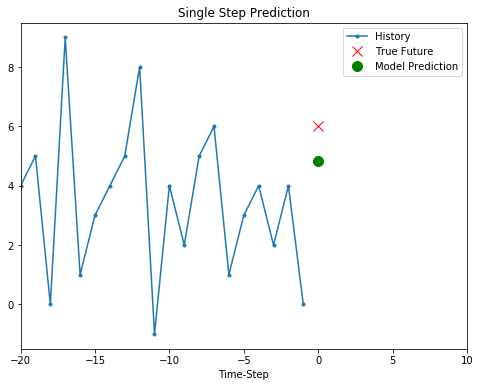

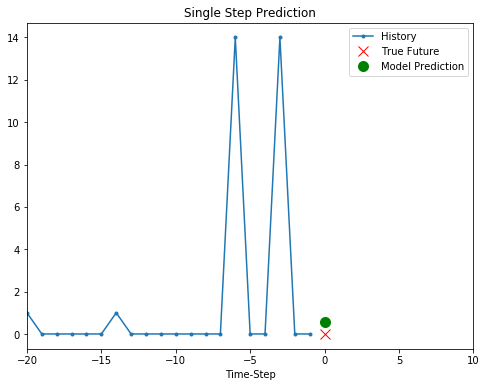

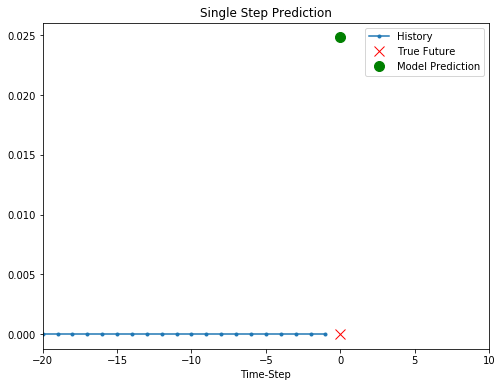

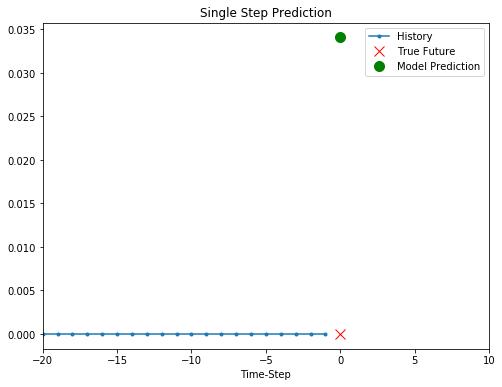

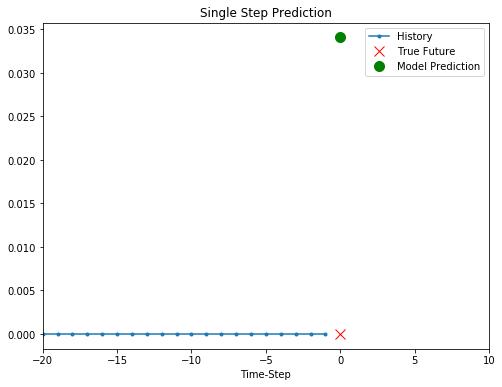

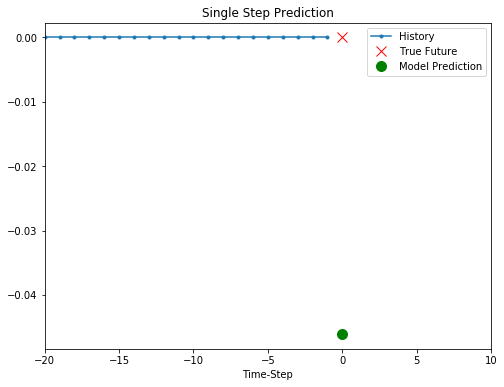

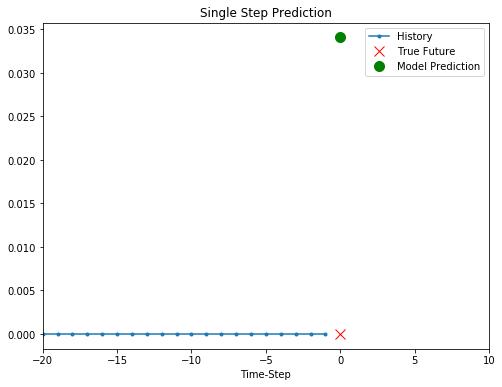

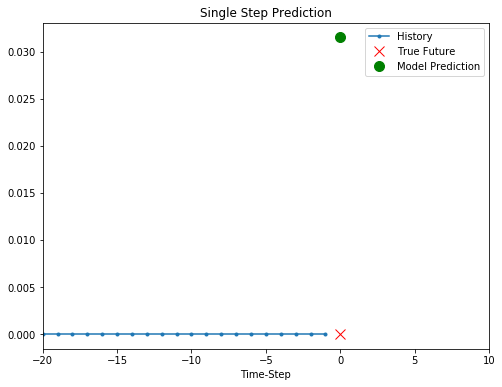

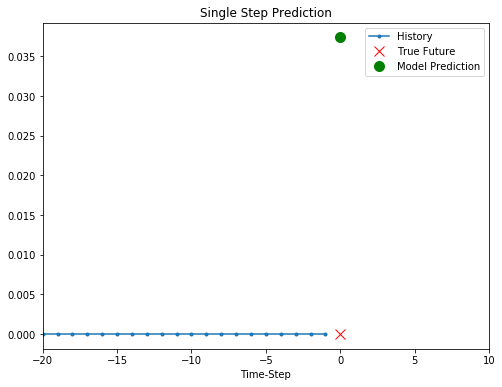

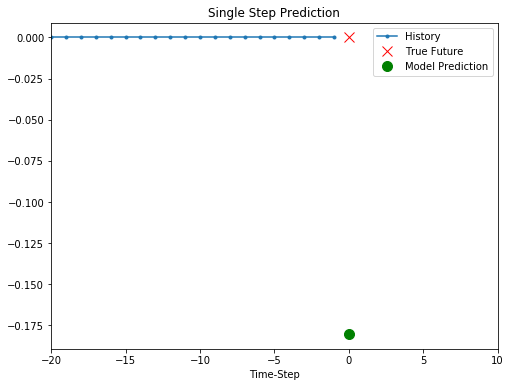

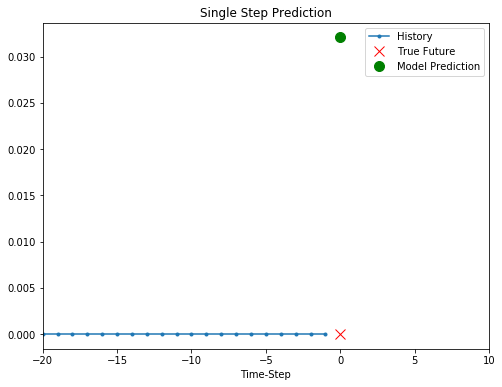

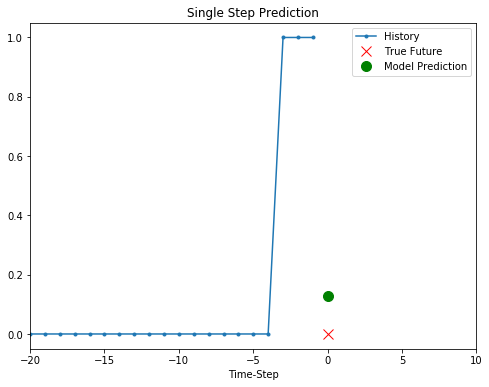

In [176]:
# shallow model
for x, y in val_data.skip(3000).take(50):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    shallow_model.predict(x)[0]], 0,
                   'Single Step Prediction')
    plot.show()

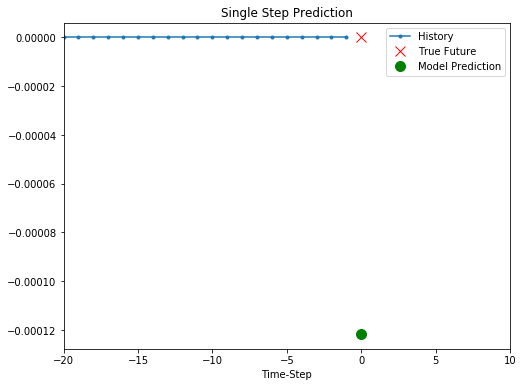

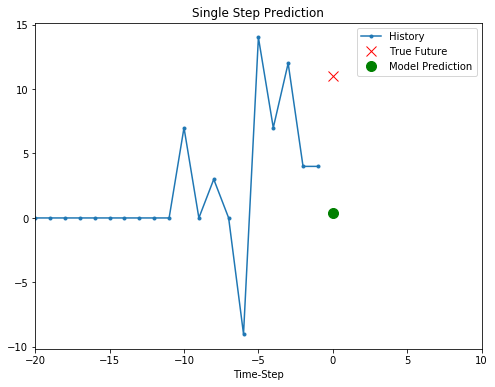

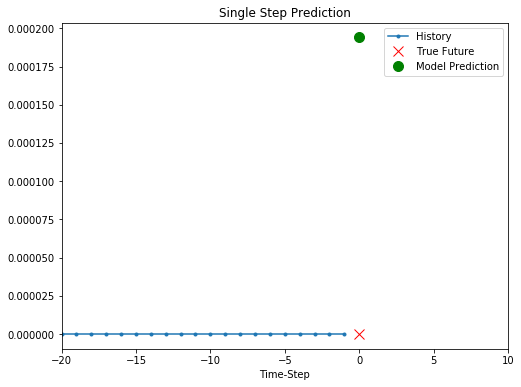

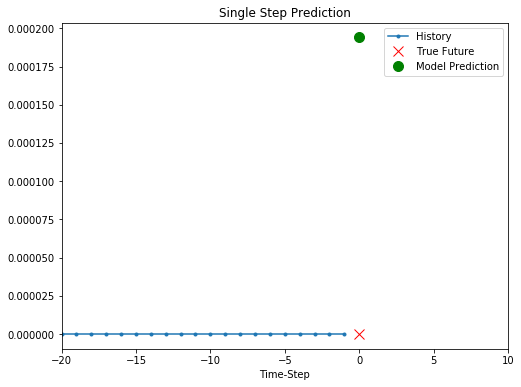

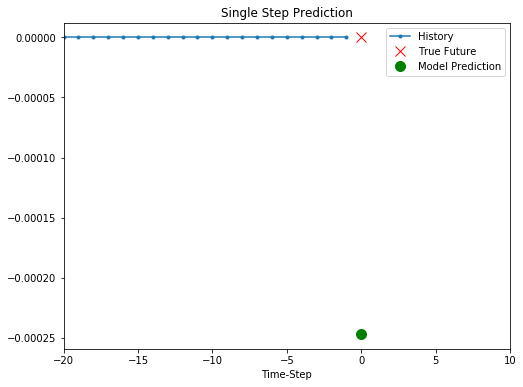

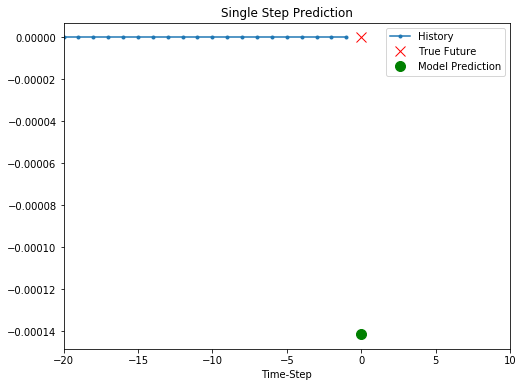

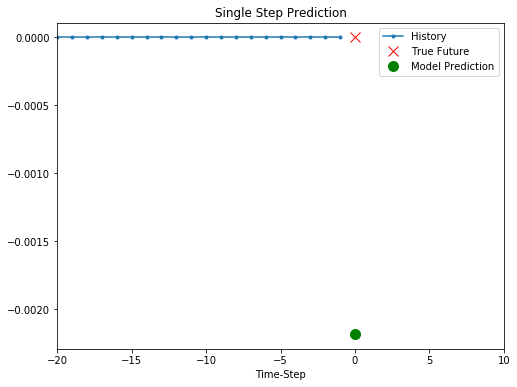

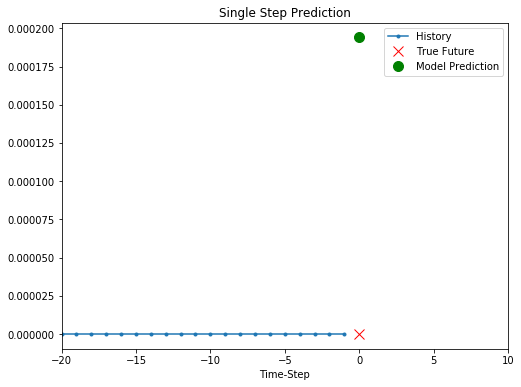

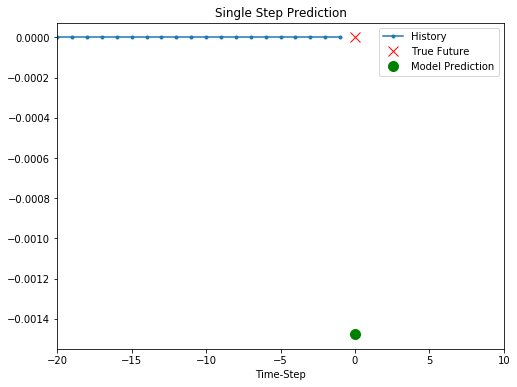

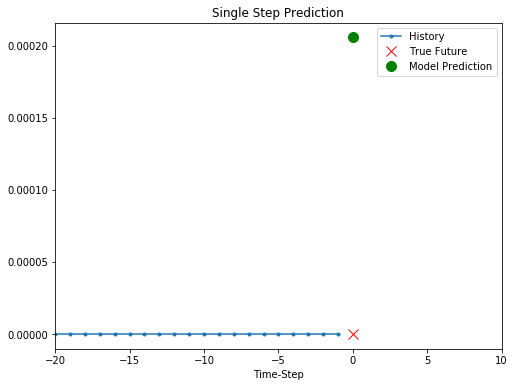

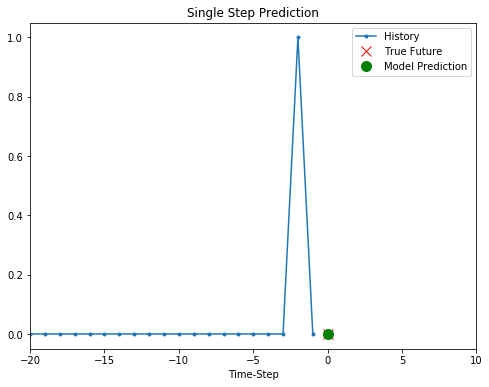

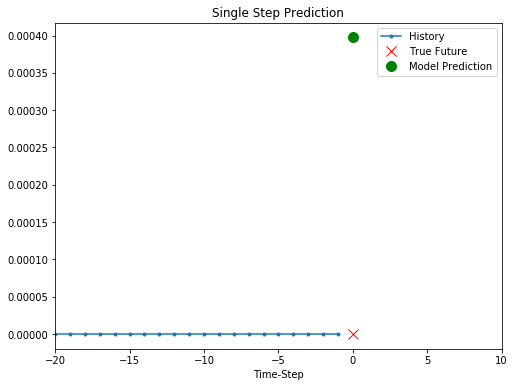

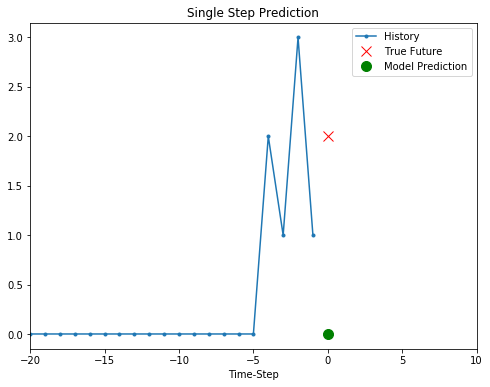

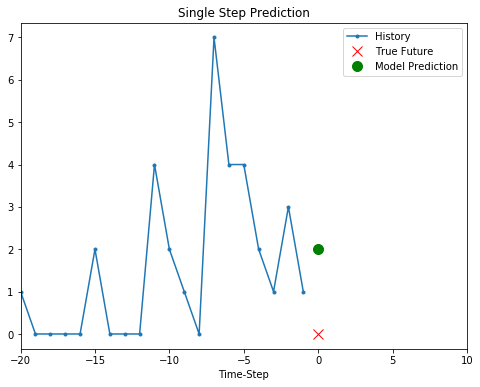

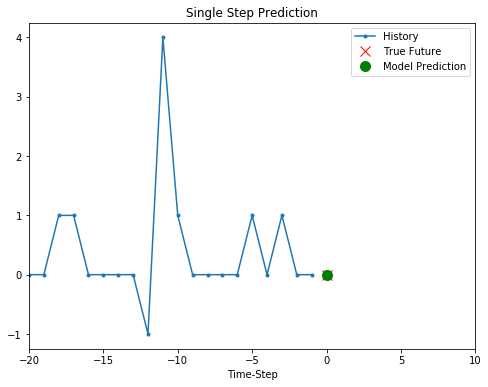

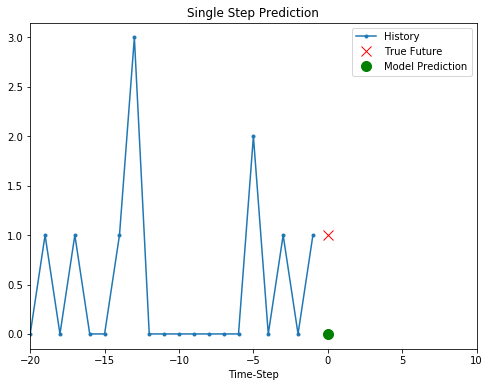

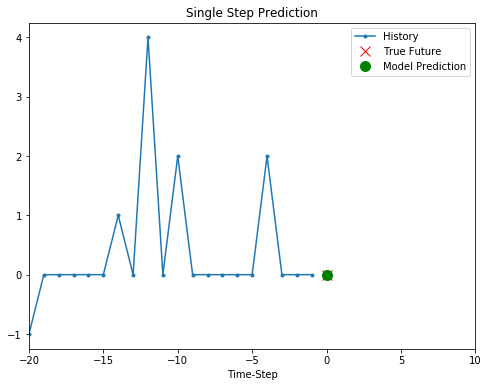

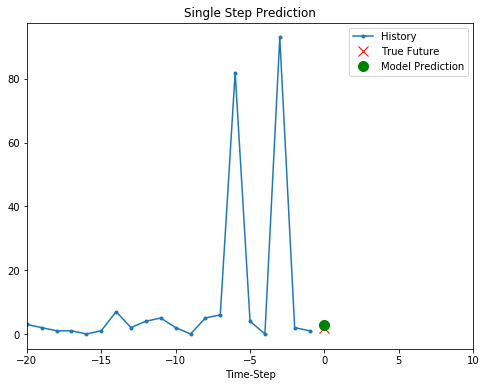

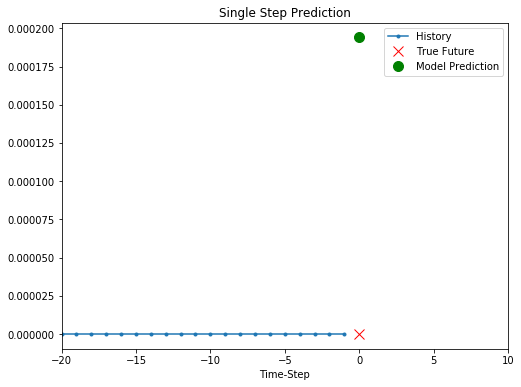

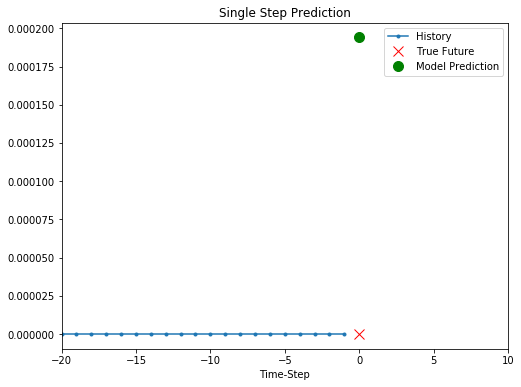

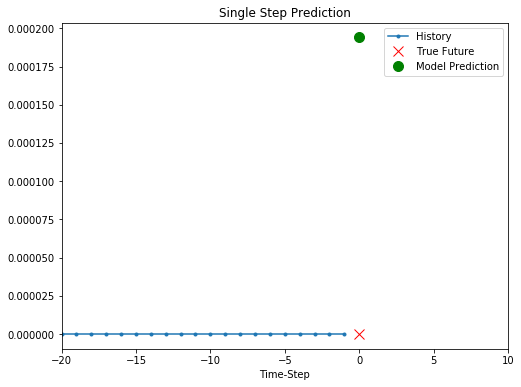

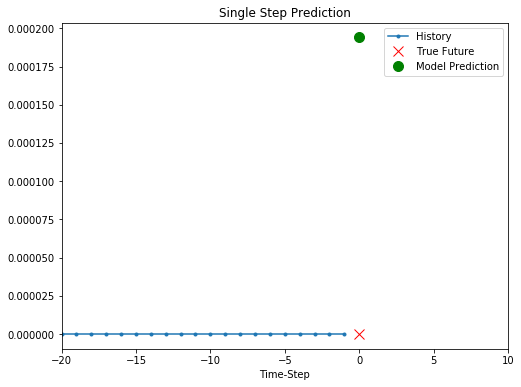

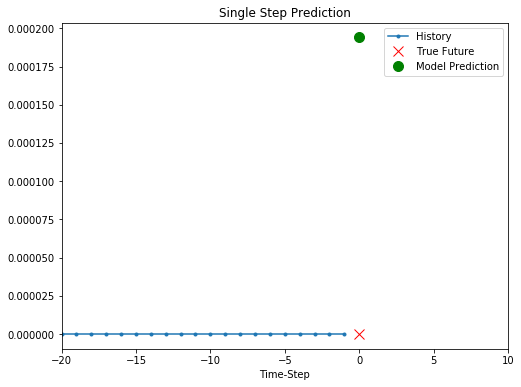

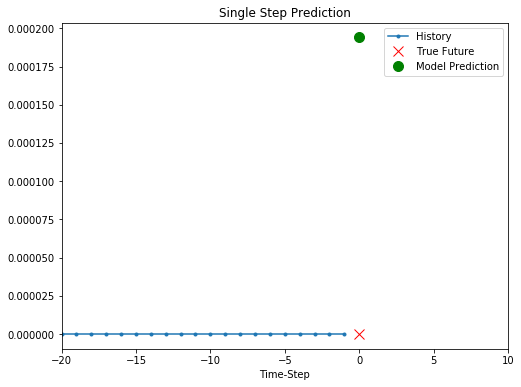

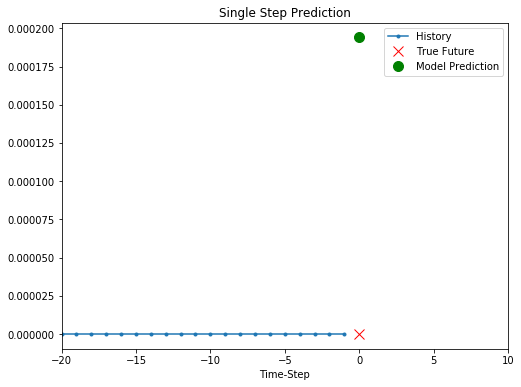

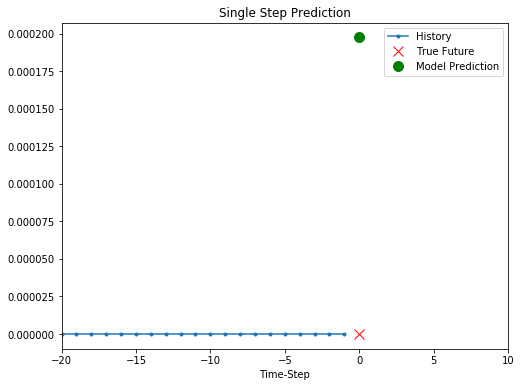

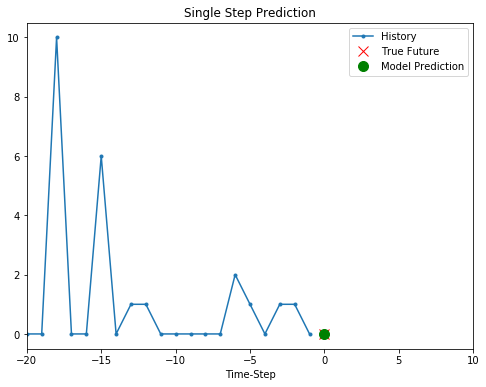

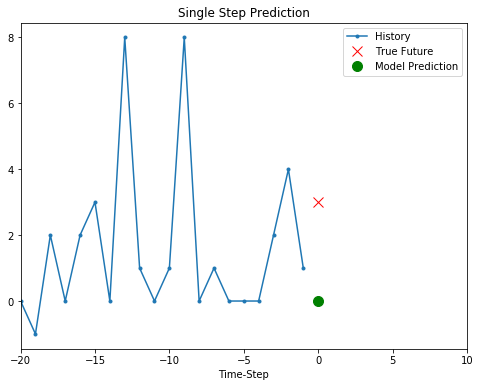

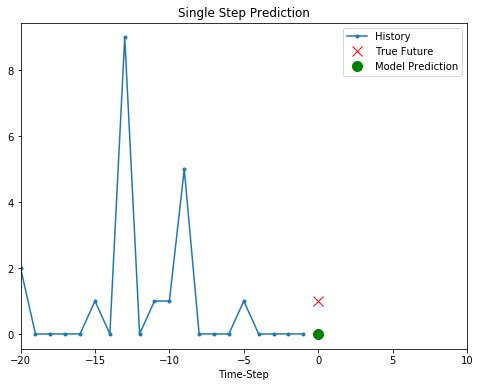

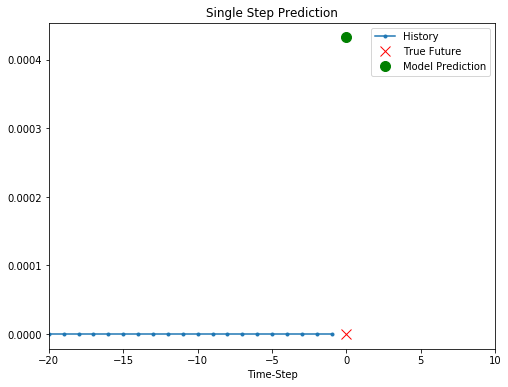

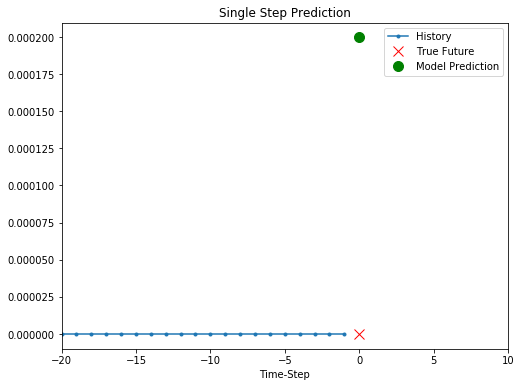

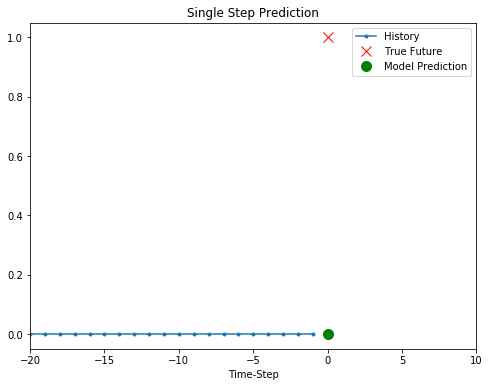

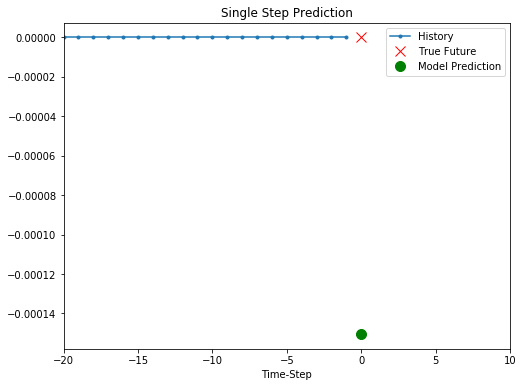

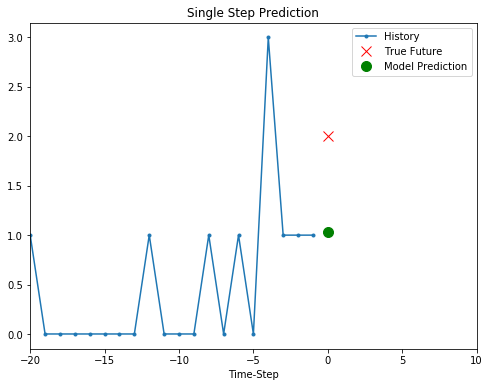

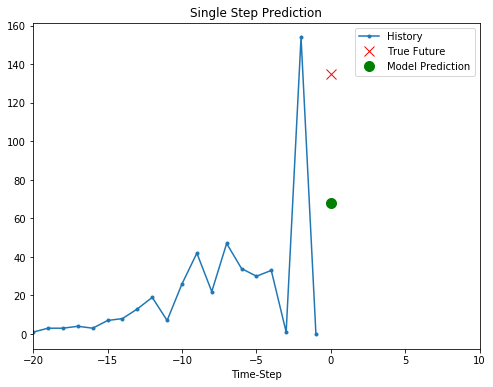

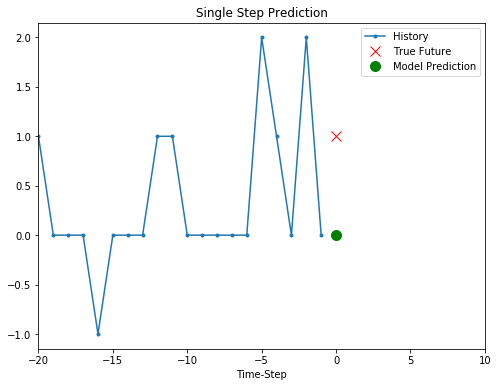

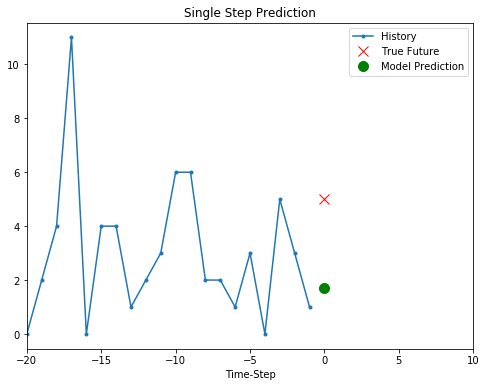

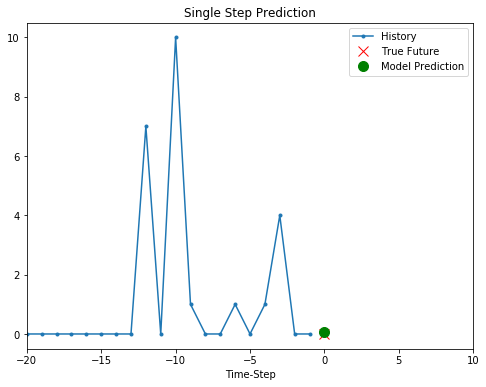

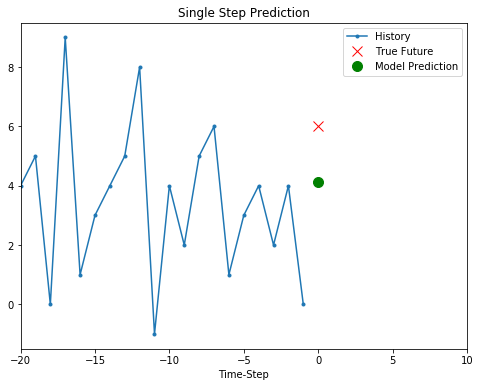

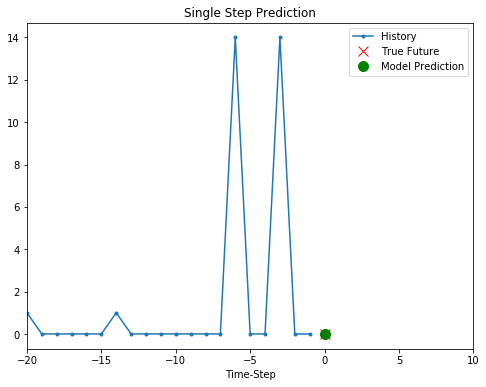

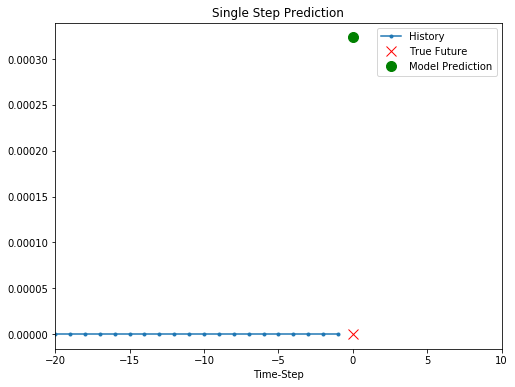

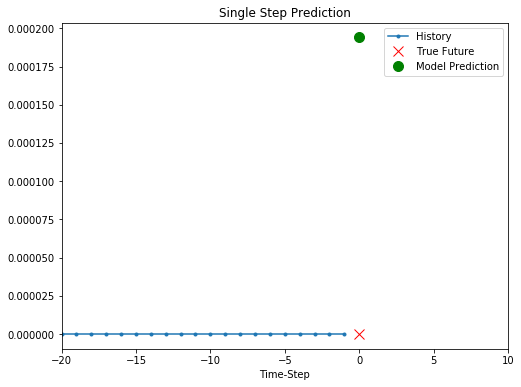

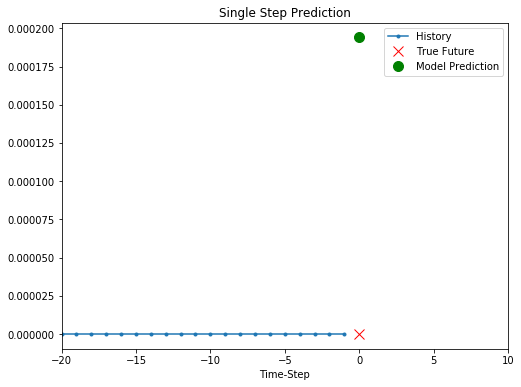

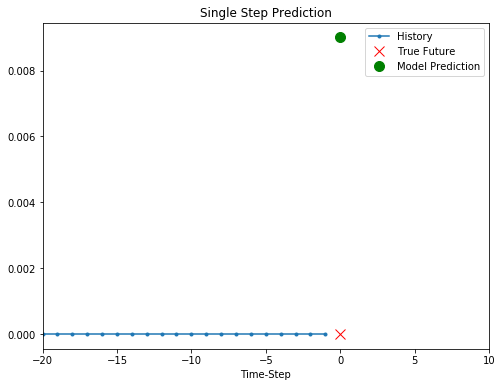

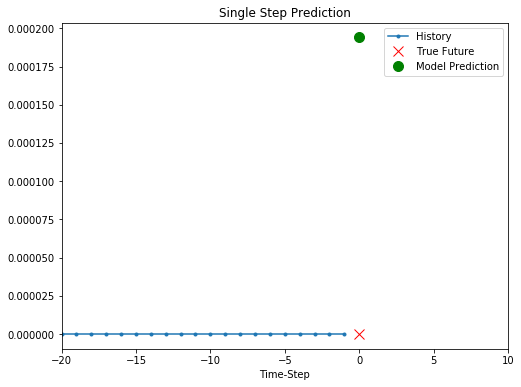

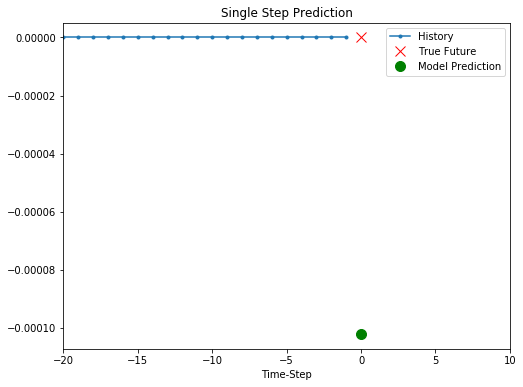

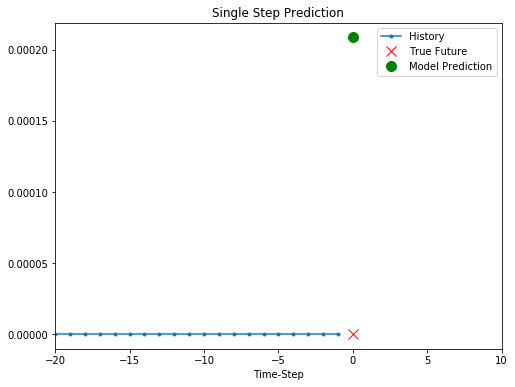

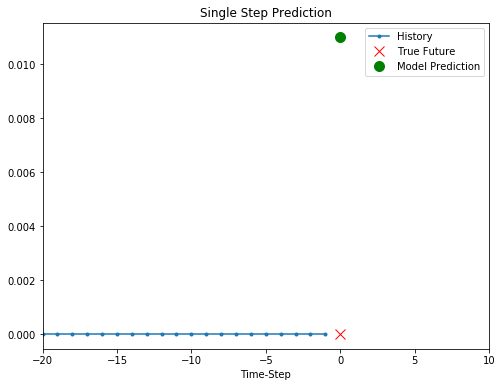

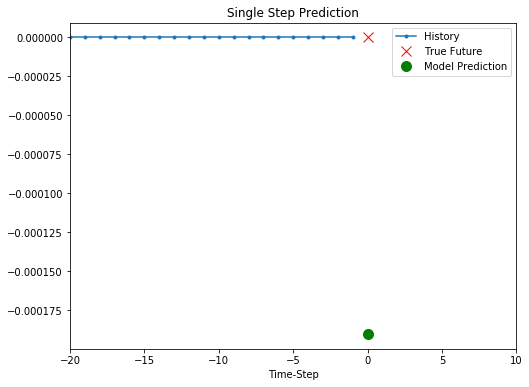

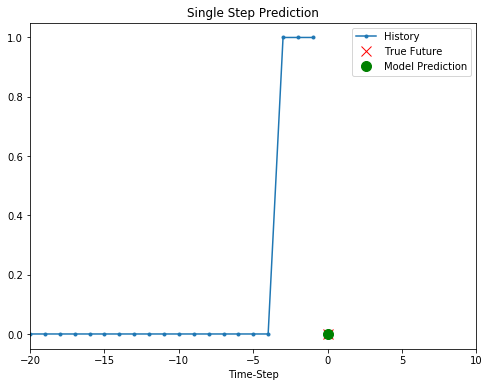

In [177]:
# deep model
for x, y in val_data.skip(3000).take(50):

    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    deep_model.predict(x)[0][0]], 0,
                   'Single Step Prediction')
    plot.show()

In [154]:
x = 0
y = 0
for x,y in val_data.skip(3000).take(10):
    pass
print(x[0][:, 1].numpy())
print( y[0].numpy())
print( model.predict(x)[0][-1])



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
-0.012613945


In [119]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [120]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

NameError: name 'train_data_multi' is not defined